In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('GAD_merged_samples_mesh.csv')

In [3]:
train = df[['raw_sentence', 'associationType']]

In [4]:
train.columns=['comment', 'recom']

In [5]:
train.head()

,comment,recom
0,This study indicates a synergistic contributio...,Y
1,The PALB2 1592delT mutation has a strong effec...,F
2,Our findings suggest that the IL-1 gene cluste...,Y
3,Advanced fibrosis but not TPMT genotype or act...,F
4,"In the light of this finding, A2A2 DRD2 genoty...",F


In [6]:
train.dropna(subset=['recom', 'comment'], inplace=True, how="any")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [7]:
train = train[train.recom != 'Y']

In [8]:
possible_labels = train.recom.unique()
possible_labels

array(['F', 'N', 'P'], dtype=object)

In [9]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'F': 0, 'N': 1, 'P': 2}

In [10]:
train

,comment,recom
1,The PALB2 1592delT mutation has a strong effec...,F
3,Advanced fibrosis but not TPMT genotype or act...,F
4,"In the light of this finding, A2A2 DRD2 genoty...",F
6,"In our population, we did not demonstrate any ...",N
7,LRRK2 mutations other than the Lrrk2 G2019S mu...,F
...,...,...
5324,Although decreased C1GALT1 activity has been i...,F
5326,We could not replicate that DLG5 is a relevant...,F
5327,The results suggest that eNOS polymorphisms (e...,F
5328,Despite the strikingly similar pathologies of ...,N


In [11]:
train['label'] = train.recom.replace(label_dict)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train['comment'], train['label'], test_size=0.2, random_state=42)

In [13]:
pip install transformers

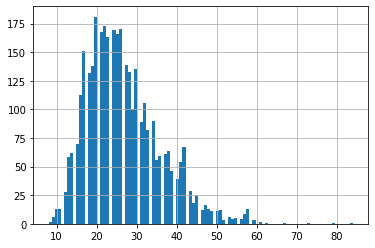

In [14]:
train['len'] = train.comment.str.split().str.len()
train['len'].hist(bins=100)

In [15]:
max_length=60

In [16]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [17]:
#bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
                                          do_lower_case=False)

In [18]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_test.values,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.values)

In [20]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

In [21]:
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [22]:
from transformers import BertForSequenceClassification

In [23]:
model = BertForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [25]:
batch_size = 16
epochs = 3

In [26]:
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

In [27]:
dataloader_validation = DataLoader(dataset_val, 
                            sampler=RandomSampler(dataset_val), 
                            batch_size=batch_size)

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [29]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score

In [32]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print('accuracy : ', accuracy_score(labels_flat, preds_flat))
    print('precision : ', precision_score(labels_flat, preds_flat, average='weighted'))
    print('recall : ', recall_score(labels_flat, preds_flat, average='weighted'))
    print('f1 : ', f1_score(labels_flat, preds_flat, average='weighted'))

    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [33]:
import random

In [34]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [35]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model.to(device)

There are 1 GPU(s) available.
Device name: Tesla K80


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [36]:
def evaluate(dataloader_val):

    # deactivate dropout layers
    model.eval()
    
    loss_val_total = 0

    # empty list to save the model predictions
    predictions, true_vals = [], []
    
    # iterate over batches
    for batch in dataloader_val:
        
        # push the batch to gpu
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        # deactivate autograd
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        # model predictions are stored on GPU. So, push it to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        predictions.append(logits)
        true_vals.append(label_ids)
    
    # compute the validation loss of the epoch
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    # reshape the predictions in form of (number of samples, no. of classes)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [37]:
for epoch in tqdm(range(1, epochs+1)):
    
    #initialize parameters and start trianing process 
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False, disable=False)
    
    for batch in progress_bar:

        # clear previously calculated gradients 
        model.zero_grad()

        # push the batch to gpu
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters (weights) and the learning rate
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
#     torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/175 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.47708810116563527
accuracy :  0.7985714285714286
precision :  0.8168594977834818
recall :  0.7985714285714286
f1 :  0.8046102204321273
Validation loss: 0.3503687676380981
F1 Score (Weighted): 0.8046102204321273


Epoch 2:   0%|          | 0/175 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3578921742950167
accuracy :  0.7971428571428572
precision :  0.836670247046187
recall :  0.7971428571428572
f1 :  0.8065354435714019
Validation loss: 0.3452718032693321
F1 Score (Weighted): 0.8065354435714019


Epoch 3:   0%|          | 0/175 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3229469511338643
accuracy :  0.8014285714285714
precision :  0.835083674526982
recall :  0.8014285714285714
f1 :  0.8099751554846129
Validation loss: 0.35806830938566814
F1 Score (Weighted): 0.8099751554846129


In [38]:
#load weights of best model
# model.load_state_dict(torch.load('finetuned_BERT_epoch_7.model'))

In [39]:
# get predictions for test data
_, predictions, true_vals = evaluate(dataloader_validation)

In [40]:
from sklearn.metrics import classification_report
y_pred_bool = np.argmax(predictions, axis=1)

In [41]:
print(classification_report(true_vals, y_pred_bool, digits=4))

              precision    recall  f1-score   support

           0     0.9233    0.7957    0.8548       514
           1     0.5914    0.8172    0.6862       186

    accuracy                         0.8014       700
   macro avg     0.7573    0.8065    0.7705       700
weighted avg     0.8351    0.8014    0.8100       700

